In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#path that contains folder you want to copy
!cp -av "/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data" "Data"

'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data' -> 'Data'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/dendeng_batokok' -> 'Data/dendeng_batokok'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/dendeng_batokok/dendeng_batokok (37).jpg' -> 'Data/dendeng_batokok/dendeng_batokok (37).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/dendeng_batokok/dendeng_batokok (41).jpg' -> 'Data/dendeng_batokok/dendeng_batokok (41).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/dendeng_batokok/dendeng_batokok (108).jpg' -> 'Data/dendeng_batokok/dendeng_batokok (108).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/dendeng_batokok/dendeng_batokok (141).jpg' -> 'Data/dendeng_batokok/dendeng_batokok (141).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/dendeng_batokok/dendeng_batokok (223).jpg' -> 'Data/dendeng_batokok/dendeng_batokok (223).jpg'
'/content/drive/MyDrive/CAPSTONE B

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
image_dir = Path('/content/Data/')

In [6]:
filepaths = list(image_dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(203, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [7]:
image_df

,Filepath,Label
0,/content/Data/gulai_tunjang/gulai_tunjang (183...,gulai_tunjang
1,/content/Data/dendeng_batokok/dendeng_batokok ...,dendeng_batokok
2,/content/Data/dendeng_batokok/dendeng_batokok ...,dendeng_batokok
3,/content/Data/gulai_tunjang/gulai_tunjang (195...,gulai_tunjang
4,/content/Data/gulai_tunjang/gulai_tunjang (139...,gulai_tunjang
...,...,...
1822,/content/Data/dendeng_batokok/dendeng_batokok ...,dendeng_batokok
1823,/content/Data/gulai_ikan/gulai_ikan (178).jpg,gulai_ikan
1824,/content/Data/telur_dadar/telur_dadar (189).jpeg,telur_dadar
1825,/content/Data/gulai_tunjang/gulai_tunjang (161...,gulai_tunjang


In [8]:
image_df['Label'].value_counts()

gulai_tunjang      203
dendeng_batokok    203
daging_rendang     203
telur_balado       203
gulai_tambusu      203
gulai_ikan         203
ayam_goreng        203
ayam_pop           203
telur_dadar        203
Name: Label, dtype: int64

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1480 validated image filenames belonging to 9 classes.
Found 164 validated image filenames belonging to 9 classes.
Found 183 validated image filenames belonging to 9 classes.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [21]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
# x = tf.keras.layers.Dropout(0.01)(x) 
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [22]:
model.compile(
    optimizer="adam",
    #tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
47/47 [==============================] - 46s 882ms/step - loss: 0.9732 - accuracy: 0.6669 - val_loss: 0.5080 - val_accuracy: 0.8415
Epoch 2/100
47/47 [==============================] - 40s 845ms/step - loss: 0.4660 - accuracy: 0.8453 - val_loss: 0.5706 - val_accuracy: 0.8232
Epoch 3/100
47/47 [==============================] - 41s 869ms/step - loss: 0.3887 - accuracy: 0.8649 - val_loss: 0.5441 - val_accuracy: 0.8049
Epoch 4/100
47/47 [==============================] - 37s 790ms/step - loss: 0.3135 - accuracy: 0.8831 - val_loss: 0.4311 - val_accuracy: 0.8659
Epoch 5/100
47/47 [==============================] - 39s 829ms/step - loss: 0.2703 - accuracy: 0.9068 - val_loss: 0.4416 - val_accuracy: 0.8598
Epoch 6/100
47/47 [==============================] - 39s 837ms/step - loss: 0.2515 - accuracy: 0.9128 - val_loss: 0.8250 - val_accuracy: 0.7500
Epoch 7/100
47/47 [==============================] - 39s 833ms/step - loss: 0.2317 - accuracy: 0.9135 - val_loss: 0.6159 - val_accuracy:

In [23]:
results = model.evaluate(test_images, verbose=2)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

6/6 - 3s - loss: 0.3933 - accuracy: 0.8525 - 3s/epoch - 450ms/step
Test Accuracy: 85.25%


In [24]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

6/6 [==============================] - 3s 301ms/step


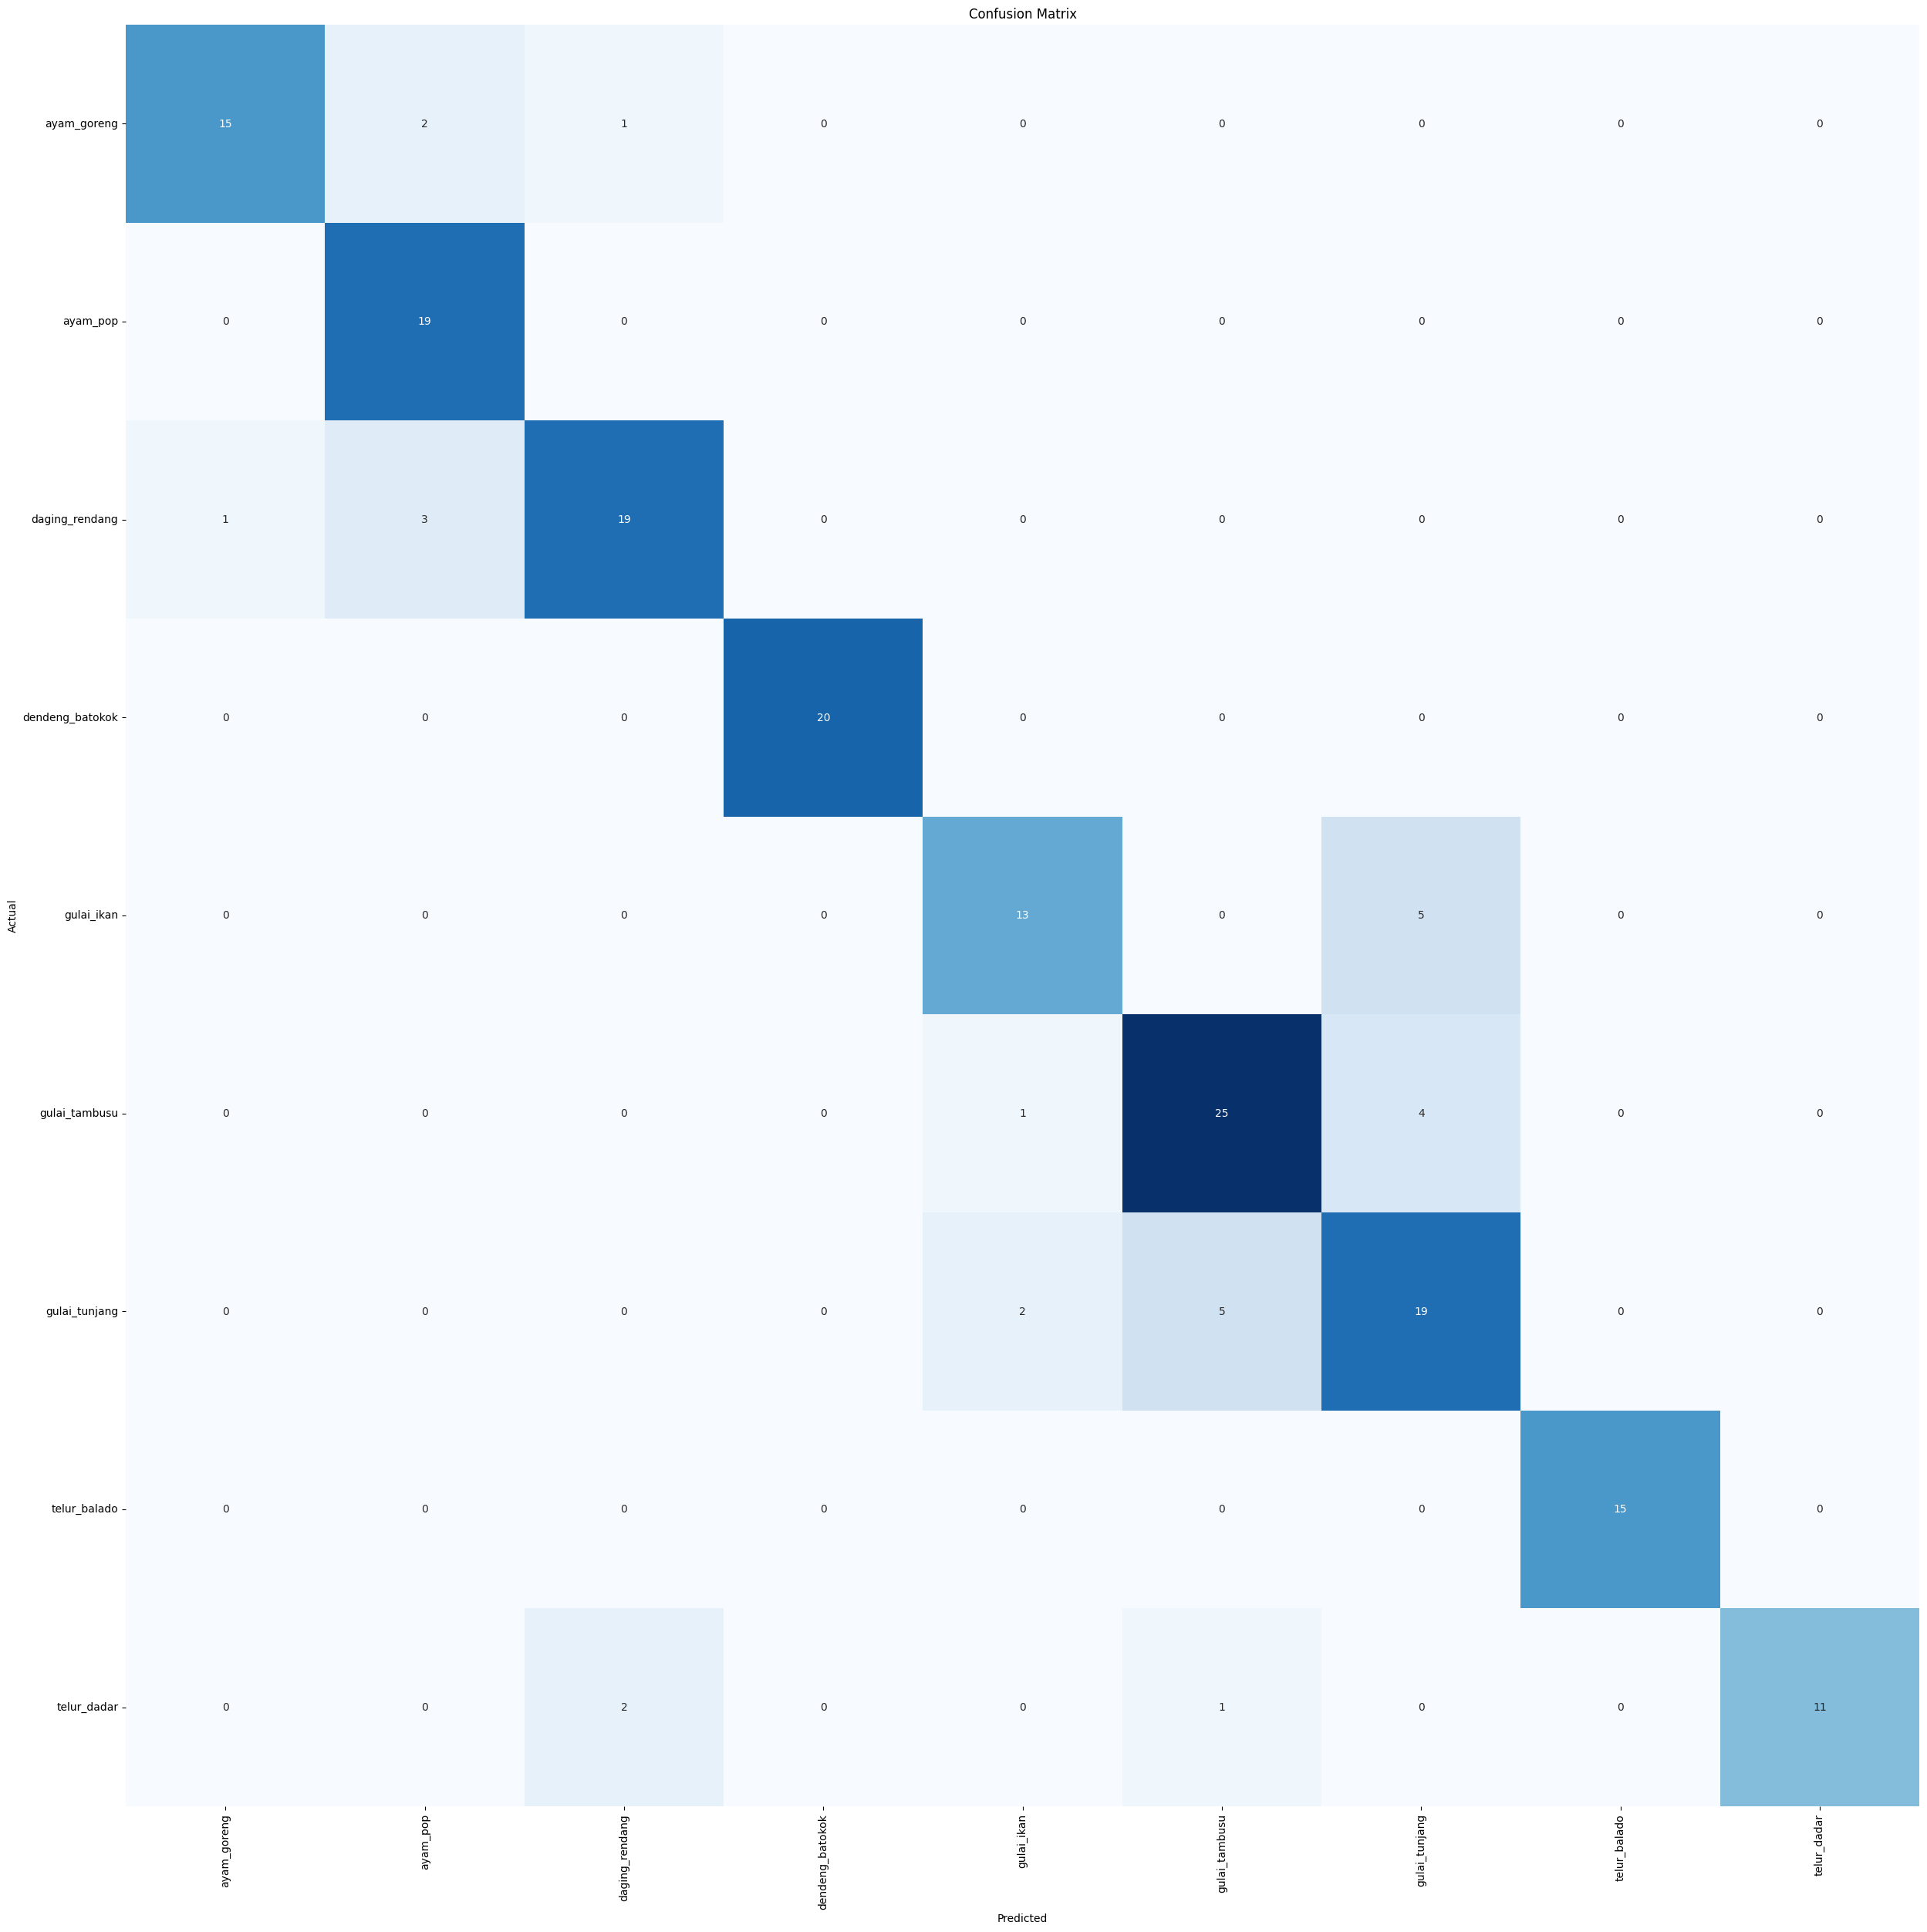

In [25]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

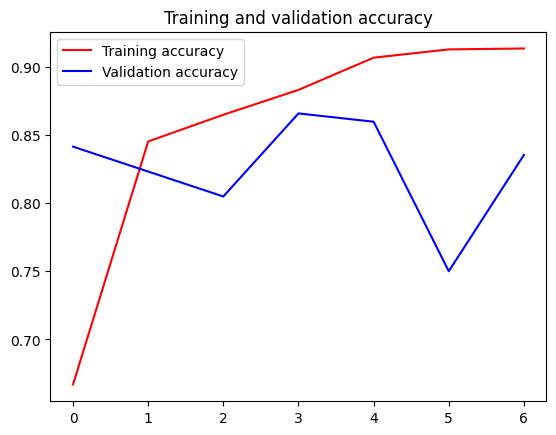

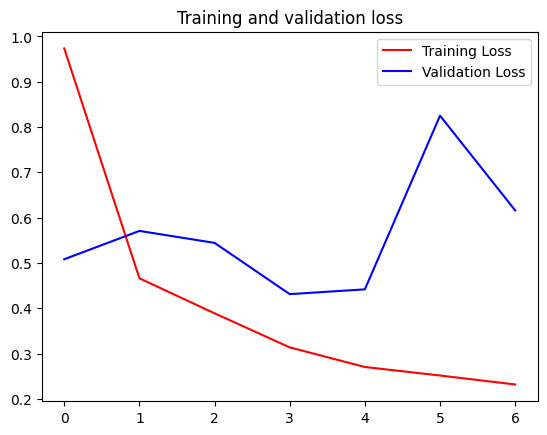

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [27]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                  precision    recall  f1-score   support

    ayam_goreng       0.94      0.83      0.88        18
       ayam_pop       0.79      1.00      0.88        19
 daging_rendang       0.86      0.83      0.84        23
dendeng_batokok       1.00      1.00      1.00        20
     gulai_ikan       0.81      0.72      0.76        18
  gulai_tambusu       0.81      0.83      0.82        30
  gulai_tunjang       0.68      0.73      0.70        26
   telur_balado       1.00      1.00      1.00        15
    telur_dadar       1.00      0.79      0.88        14

       accuracy                           0.85       183
      macro avg       0.88      0.86      0.86       183
   weighted avg       0.86      0.85      0.85       183



In [20]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

labels = ["Ayam goreng", "Ayam pop", "Daging Rendang", "Dendeng Batokok", "Gulai Ikan", "Gulai Tambusu", "Gulai Tunjang", "Telur balado", "Telur dadar"]

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=32)

    highest_score_index = np.argmax(classes)
    highest_score = classes[0][highest_score_index]
    highest_score_label = labels[highest_score_index]

    print(classes)
    print("Highest Score:", highest_score)
    print("Highest Score Label:", highest_score_label)


Saving telorrz.jpg to telorrz.jpg
1/1 [==============================] - 2s 2s/step
[[1.31377601e-03 3.07648033e-01 2.23117531e-03 1.91961764e-04
  2.10731357e-01 4.50445749e-02 2.77996600e-01 1.52408155e-02
  1.39601752e-01]]
Highest Score: 0.30764803
Highest Score Label: Ayam pop
